In this report, we will develop a survival analysis on the mortgage dataset and we will analyse the probabilities of default of the mortgages over time . We will also interpret the impact of the variables of the dataset on the probability of default over time.

In [58]:
import lifelines # pip install lifelines
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter

In [11]:
# load dataset
mortgage= pd.read_csv('./Assignment2022_Data/mortgage.csv')

In [12]:
mortgage.shape

(622489, 23)

In [13]:
# Transforming the target variable from 3 categories into two by converting 2 to 0
mortgage['status_time'] = mortgage['status_time'].replace({2:0})

In [14]:
mortgage['status_time'].value_counts()

0    607331
1     15158
Name: status_time, dtype: int64

In [15]:
# Checking missing values
mortgage.isna().sum()

id                           0
time                         0
orig_time                    0
first_time                   0
mat_time                     0
balance_time                 0
LTV_time                   270
interest_rate_time           0
hpi_time                     0
gdp_time                     0
uer_time                     0
REtype_CO_orig_time          0
REtype_PU_orig_time          0
REtype_SF_orig_time          0
investor_orig_time           0
balance_orig_time            0
FICO_orig_time               0
LTV_orig_time                0
Interest_Rate_orig_time      0
hpi_orig_time                0
default_time                 0
payoff_time                  0
status_time                  0
dtype: int64

In [20]:
# Dropping missing values
mortgage.dropna(subset=['LTV_time'], how='all', inplace=True)

In [21]:
mortgage.shape

(622219, 23)

<AxesSubplot:ylabel='status_time'>

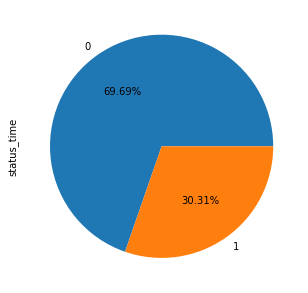

In [22]:
mortgage.groupby("id").agg({"status_time":np.max})["status_time"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))

In [23]:
# convert episodic data to static
mortgage_static = mortgage.groupby("id").agg(np.max).reset_index()

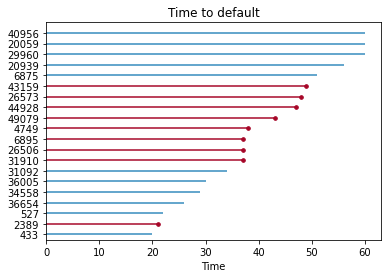

In [24]:
from lifelines.plotting import plot_lifetimes

df_samp = mortgage_static.sample(20)
ax = plot_lifetimes(df_samp["time"], event_observed=df_samp["status_time"])
ax.set_xlabel("Time")
ax.set_title("Time to default")
plt.show()

##  Kaplan-Meier model

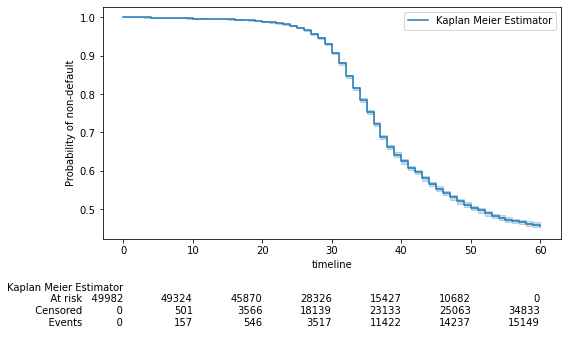

In [25]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
# fit on static data: TIME indicates the last observed timestep, TARGET indicates whether the customer defaulted
kmf.fit(mortgage_static['time'], mortgage_static['status_time'], label='Kaplan Meier Estimator')

# plot survival function
ax = kmf.plot_survival_function(at_risk_counts=True,figsize=(8,5))
ax.set_ylabel('Probability of non-default')
plt.show()

In [30]:
mortgage_static['balance_orig_time'].quantile(q=0.3)

127900.0

In [32]:
# subsettting into two tables: less than 127900 and more than 127900
less = mortgage_static[mortgage_static['balance_orig_time'] < 127900]
more = mortgage_static[mortgage_static['balance_orig_time'] >= 127900]

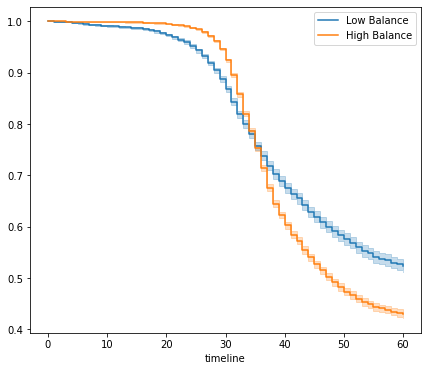

In [40]:
# Comparing two groups using kaplan Meiier model
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, ax = plt.subplots(1,1 , figsize=(7,6))
ax = kmf1.fit(less['time'], less['status_time'], label='Low Balance').plot_survival_function(ax=ax)
ax = kmf2.fit(more['time'], more['status_time'], label='High Balance').plot_survival_function(ax=ax)
plt.show()

### Test Significance between the two groups

In [38]:
# Perform logrank test to assess whether there is a difference between Males and Females in time to default

from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
res = logrank_test(less['time'], more['time'], event_observed_A=less['status_time'],event_observed_B=more['status_time'])


res.summary 

,test_statistic,p,-log2(p)
0,58.647544,1.886034e-14,45.591637


We conclude that there is significant difference between the two groups since we reject the null hypothesis because p value < 0.05.
By looking at the graph, we see that  on the 20th month the difference between the two groups starts increasing because the probabilty of survival for the low balance group starts decreasing after ~20 month whereas the high balance groups'probabilty starts decreasing after ~25 months. We notice that after ~37 months the probabilty of survival for high balance group becomes lower than the high balance group and that is because the decrease of probabilty for high balance group was more steep than the other group. AFter the ~37th month, the difference increases between the two groups until it reaches a constant difference after 50 months.


## Cox Proportional Hazard model

This model helps us identify the importance of features over the probabilty of survival.

In [65]:
mortgage_cp = mortgage[["default_time", "hpi_time", "gdp_time", "uer_time", "balance_time",
"interest_rate_time", "FICO_orig_time", "LTV_time", "id", 'time']]
mortgage_cp["beg_time"] = 0

<ipython-input-65-9d0c9ce6f37e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortgage_cp["beg_time"] = 0


In [66]:
mortgage_cp

,default_time,hpi_time,gdp_time,uer_time,balance_time,interest_rate_time,FICO_orig_time,LTV_time,id,time,beg_time
0,0,226.29,2.899137,4.7,41303.42,9.200,715,24.498336,1,25,0
1,0,225.10,2.151365,4.7,41061.95,9.200,715,24.483867,1,26,0
2,0,222.39,2.361722,4.4,40804.42,9.200,715,24.626795,1,27,0
3,0,219.67,1.229172,4.6,40483.89,9.200,715,24.735883,1,28,0
4,0,217.37,1.692969,4.5,40367.06,9.200,715,24.925476,1,29,0
...,...,...,...,...,...,...,...,...,...,...,...
622484,0,181.43,1.717053,6.6,517107.42,2.664,653,57.659403,50000,56,0
622485,0,187.20,2.556052,6.2,512274.57,2.652,653,55.359916,50000,57,0
622486,0,188.37,2.868594,6.2,507396.72,2.644,653,54.492206,50000,58,0
622487,0,187.65,2.443648,5.7,502478.87,2.638,653,54.171106,50000,59,0


In [67]:
from lifelines import CoxPHFitter

ctv = CoxTimeVaryingFitter()

# fit model on static data
# here the target is 'default_time' as specified by the question that it is included in the selected variables, noting that default_time and 'status_time are highly correlated so can't fit them both in the coxfitter
ctv.fit(mortgage_cp, start_col='beg_time', stop_col="time", event_col='default_time')
ctv.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hpi_time,3.232941e-02,1.032858,9.703907e-04,3.042748e-02,3.423134e-02,1.030895,1.034824,0.0,33.315868,2.274861e-243,806.042748
gdp_time,-3.199794e-01,0.726164,5.349371e-03,-3.304639e-01,-3.094948e-01,0.718590,0.733818,0.0,-59.816260,0.000000e+00,inf
uer_time,-2.625634e-01,0.769078,1.027439e-02,-2.827008e-01,-2.424259e-01,0.753745,0.784722,0.0,-25.555127,4.815499e-144,476.089960
balance_time,6.558453e-07,1.000001,1.829275e-08,6.199922e-07,6.916984e-07,1.000001,1.000001,0.0,35.852755,1.665976e-281,932.725427
interest_rate_time,2.254830e-01,1.252928,3.108010e-03,2.193914e-01,2.315746e-01,1.245319,1.260583,0.0,72.548994,0.000000e+00,inf
FICO_orig_time,-3.559583e-03,0.996447,1.203194e-04,-3.795405e-03,-3.323761e-03,0.996212,0.996682,0.0,-29.584441,2.369242e-192,636.565769
LTV_time,8.830032e-03,1.008869,1.228313e-04,8.589287e-03,9.070777e-03,1.008626,1.009112,0.0,71.887453,0.000000e+00,inf
id,-1.002464e-05,0.999990,5.534039e-07,-1.110929e-05,-8.939985e-06,0.999989,0.999991,0.0,-18.114504,2.448689e-73,241.208741


<AxesSubplot:xlabel='log(HR) (95% CI)'>

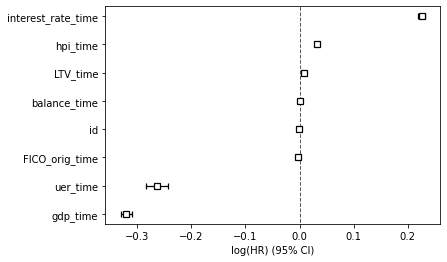

In [68]:
ctv.plot()

In [69]:
print(ctv.params_)

covariate
hpi_time              3.232941e-02
gdp_time             -3.199794e-01
uer_time             -2.625634e-01
balance_time          6.558453e-07
interest_rate_time    2.254830e-01
FICO_orig_time       -3.559583e-03
LTV_time              8.830032e-03
id                   -1.002464e-05
dtype: float64


The variables interest_rate_time, uer_time and gdp_time have the highest impact on the probabilty of survival. In the graph above, the variables whose log(HR)are  on the right of the dashed line, like interest_rate_time and hpi_time,  have an inverse impact on the probability of survival (or probabilty of default), meaning the additional unit of the variable decreases the probabilty of survival. The oppposite applies for the variables with the log(HR) on the left, meaning an additional unit of the variables increases the probability of survival. The bigger the distance betwene the lo(HR) of the variable and the dashed line, the more impact it has on probabilty of survival (or probabilty of default).